<a href="https://colab.research.google.com/github/Done-Yang/MachineLearning/blob/main/StarterProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Frame the problems


- in califonia
- To prediction of a district's median housing price
- Housing price are currently extimate manualy by expert

#### Sytem sesigning
- train as supervised kind
- regression task
- train as bath learning

## Get the Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

### Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### Take a Quick Look at the Data Structure

In [2]:
## list 5 line on the top head()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
## quick description of the data info()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
## categories the duplicate row value_counts()
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
## summary of the numerical attributes describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The following cell is not shown either in the book. It creates the `images/end_to_end_project` folder (if it doesn't already exist), and it defines the `save_fig()` function which is used through this notebook to save the figures in high-res for the book.

In [6]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

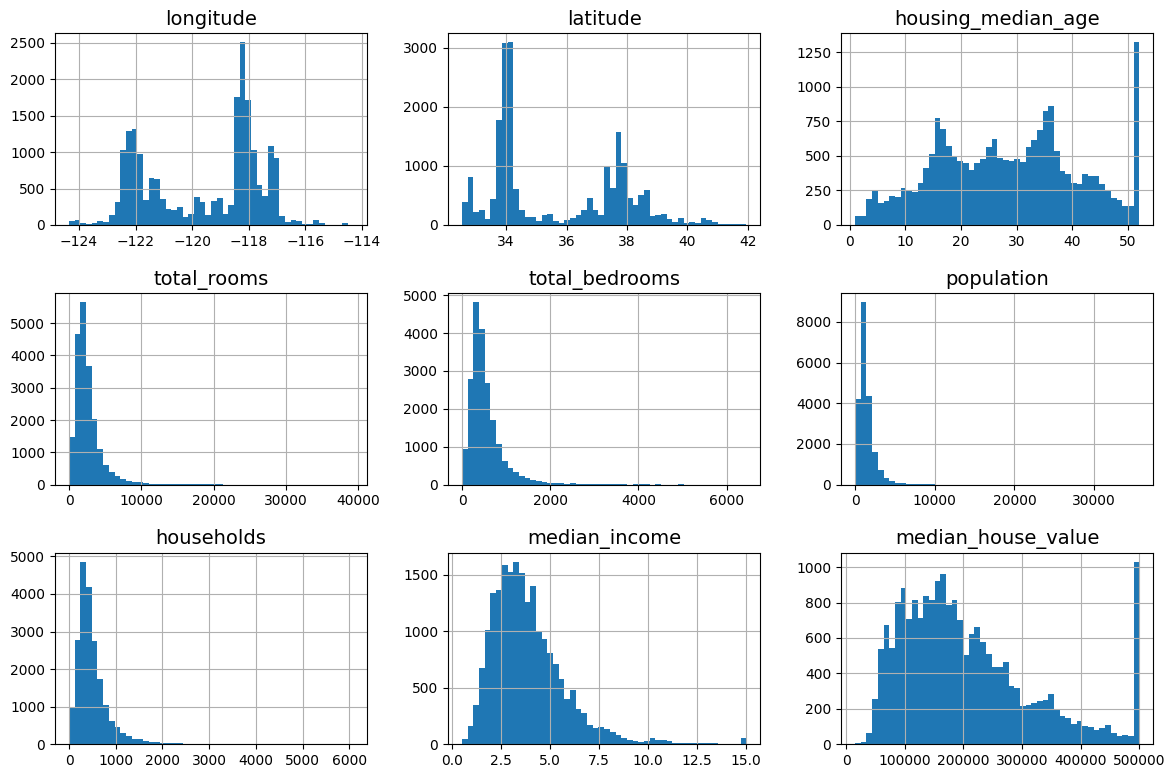

In [7]:
## to plotting the histogram for each nnumerical attribute
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

### Create test set


In [8]:
from zlib import crc32
import numpy as np

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
## indentifier the column by adding index

housing_with_id = housing.reset_index()  ## add an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print("--------train set----------")
print(train_set)

print("--------test set----------")
print(test_set)

--------train set----------
       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
6          6    -122.25     37.84                52.0       2535.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1  

In [10]:
## To stable feature to build a unique identifier

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print("--------train set----------")
print(train_set)

print("--------test set----------")
print(test_set)

--------train set----------
       index  longitude  latitude  housing_median_age  total_rooms  \
0          0    -122.23     37.88                41.0        880.0   
1          1    -122.22     37.86                21.0       7099.0   
2          2    -122.24     37.85                52.0       1467.0   
3          3    -122.25     37.85                52.0       1274.0   
4          4    -122.25     37.85                52.0       1627.0   
...      ...        ...       ...                 ...          ...   
20635  20635    -121.09     39.48                25.0       1665.0   
20636  20636    -121.21     39.49                18.0        697.0   
20637  20637    -121.22     39.43                17.0       2254.0   
20638  20638    -121.32     39.43                18.0       1860.0   
20639  20639    -121.24     39.37                16.0       2785.0   

       total_bedrooms  population  households  median_income  \
0               129.0       322.0       126.0         8.3252   
1  

In [11]:
## Scikit-learn few function to split dataset into multiple subset in various ways

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the binomial distribution. The cdf() method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [13]:
##  simulations with binom() of scipy

from scipy.stats import binom

sample_size = 1000
ration_female = 0.511
proba_too_small = binom(sample_size, ration_female).cdf(485- 1)
proba_too_larg = 1 - binom(sample_size, ration_female).cdf(535)

print(proba_too_small + proba_too_larg)

0.10736798530929942


In [14]:
## simulations over maths

import numpy as np

sample = (np.random.rand(100_000, sample_size) < ration_female).sum(axis=1)
((sample < 485) | (sample > 535)).mean()

0.10737

In [15]:
## To create an income category attribute with 5 categories

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

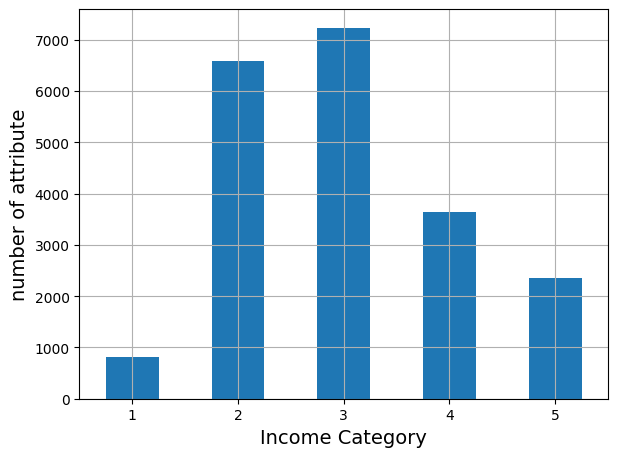

In [16]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
save_fig("income_cat_bar_plot")
plt.xlabel("Income Category")
plt.ylabel("number of attribute")
save_fig("housing_icome_cat_bar_plot")

In [17]:
## To be prcise sould split the training and test indices

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [19]:
 ## measure the income category proportion in the full dataset
import pandas as pd

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [20]:
## Back everything of the data to the original state

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visulize the Data to Gain Insights

In [21]:
## Make a copy the original for revert to it afterward
housing = strat_train_set.copy()

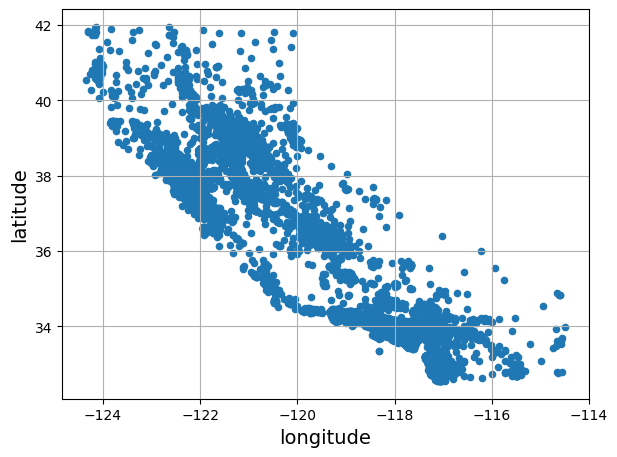

In [22]:
## Sisualize geographical data

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")

plt.show()

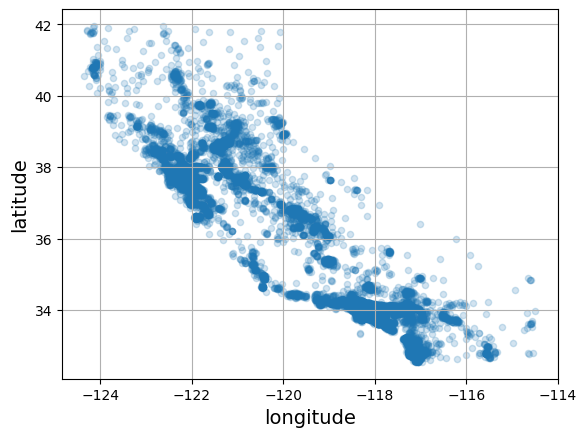

In [23]:
## To make it much esier to visulize the place (alpha=0.2)

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

plt.show()

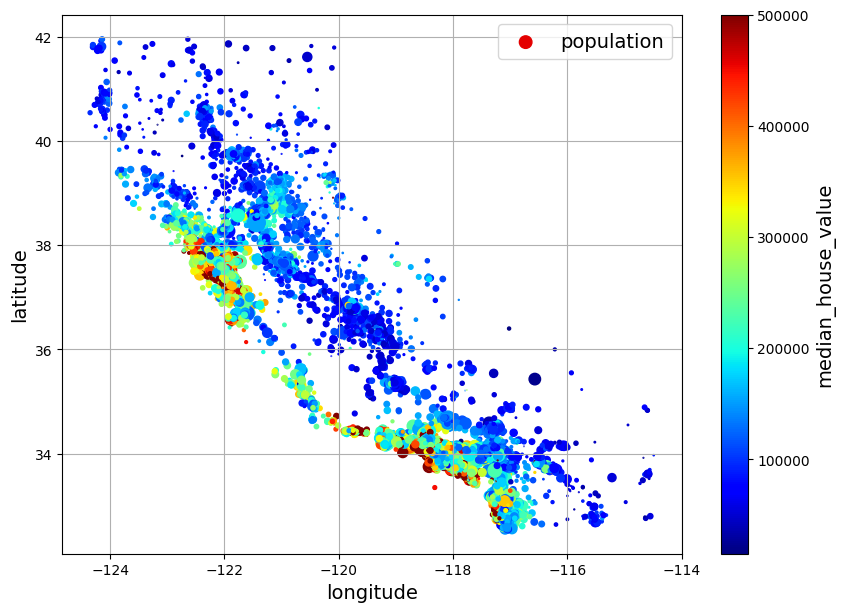

In [24]:
## Housing price as the color

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100,
             label="population", c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

plt.show()

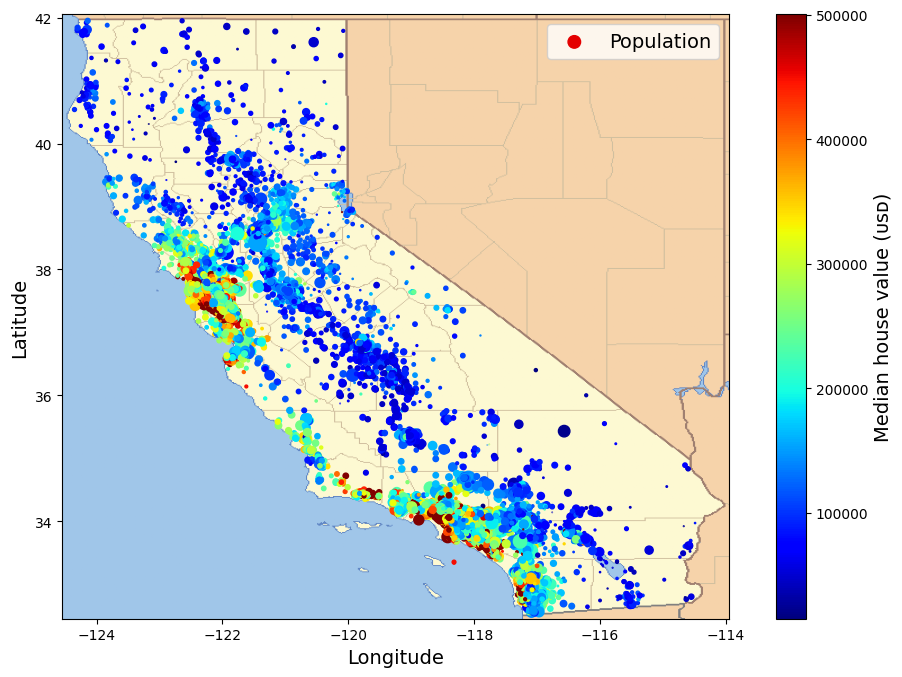

In [25]:
## nicer label names and no grid

# Download the colifonia image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

In [26]:
## To look for correlation or compute the standard correlation coefficient (Pearson's r) between every pair of attribute  corr()

corr_matrix = housing.corr(numeric_only=True)

In [27]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


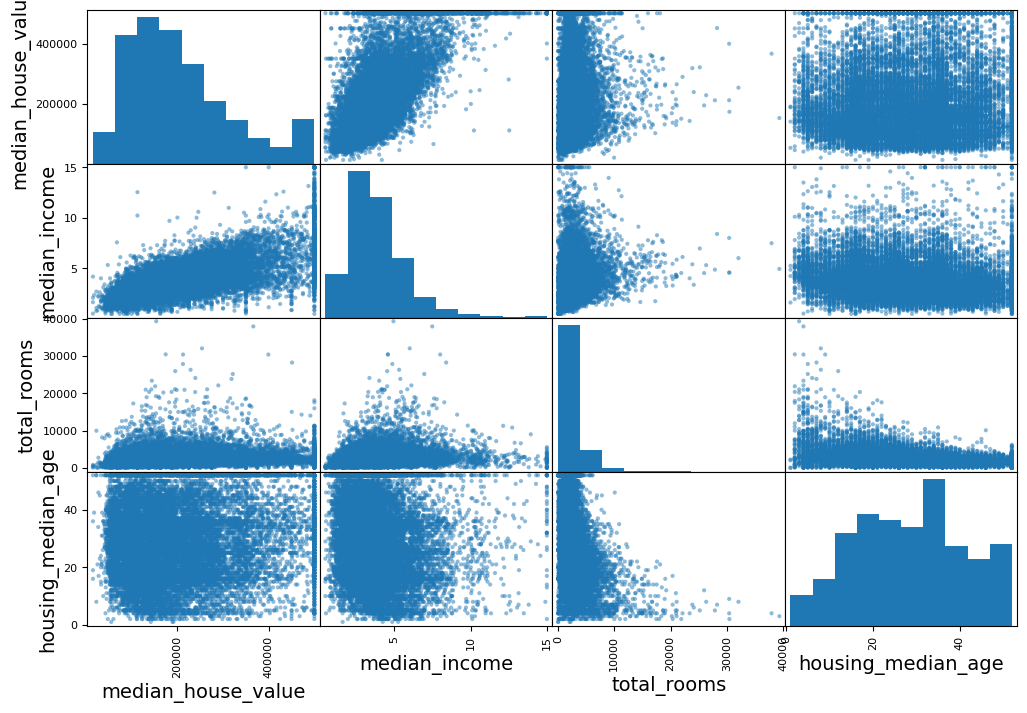

In [29]:
## To plot the every numerical attributes against every other numerical attribute

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

plt.show()

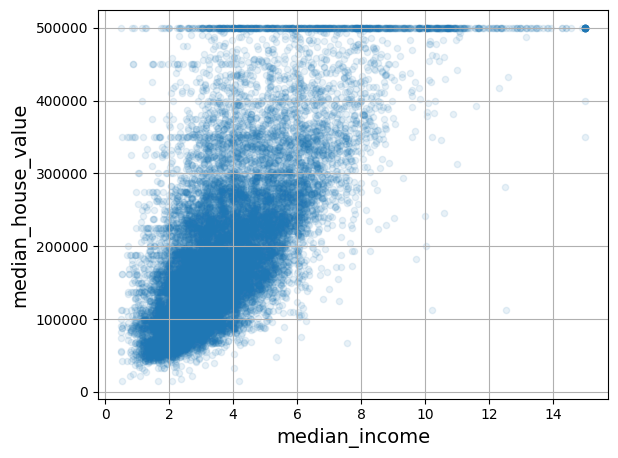

In [30]:
## To zoom in on the scatterplot
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

In [31]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


Experimenting with Attribute Combinations

In [32]:
## Create new attribute to the housing

housing['rooms_per_house11'] = housing['total_rooms'] / housing['households']
housing['badrooms_ration'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_hous'] = housing['population'] / housing['households']




In [33]:
housing


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house11,badrooms_ration,people_per_hous
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,4.511933,0.230891,2.058473


In [34]:
## Look at the correlation

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house11,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_hous,-0.038224
longitude,-0.050859


## Prepare the Data for Machine Learning

In [35]:
## Create a copy of the data that does not affect strat_train_set

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

print(housing )

print("--------housing_labels----------")
print(housing_labels)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  median_income ocean_

#### Data Cleaning


For each option, we'll create a copy of housing and work on that copy to avoid breaking housing. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [36]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [37]:
## To accomplish the attribute has missing values

housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [38]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [39]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

<ipython-input-39-b6dffbe9d505>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [40]:
## To replace the median to the missing value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [41]:
## Tp create a compy of the data with the only numerical attribute

housing_num = housing.select_dtypes(include=[np.number])

In [42]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [44]:
## Check that this is the same as manually computing the median of each attribute

housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [45]:
## Transform the training set

X = imputer.transform(housing_num)

In [46]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [48]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [49]:
imputer.strategy

'median'

In [50]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


In [51]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


Now let's drop some outliers:

In [52]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [53]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [54]:
## If want to drop the outliers, you would like to run this code

#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Handling Text and Categorical Attributes

In [55]:
#  preprocess the categorical input feature "ocean_proximity"

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [56]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [57]:
# to show the category

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [58]:
# make one-hot encoding

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [59]:
# By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [60]:
# Set sparse_output=False then it will return a regular (dense) Numpy array directly

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [61]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [62]:
# To convert each categorycal feature to one-hot representation get_dummies()

df_test = pd.DataFrame({"ocean_proximity": ["NEAR BAY", "NEAR OCEAN"]})
pd.get_dummies(df_test)

,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,True,False
1,False,True


In [71]:
# transform the categories of feature to one-hot

cat_encoder.transform(df_test)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [72]:
# The different between get_dummies() and OneHotEncoder()
# get_dummies() show the len of column that given whereas OneHotEncoder() output one column per learned category
# get_dummies() will happly generate an unknow catagory column for it

df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]}) # "<2H OCEAN" not included in columns
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [73]:
# but OneHotEncoder() smarter, it detect unknow category and rais an exception

cat_encoder.handle_unknown = "ignore"  #To handling the unknow catagory
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [78]:
# To ensure that the DataFrame fed to this estimator after that has the same column names "feature_names_in_"
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [82]:
# To build a DataFrame around the transformer's output  get_feature_names_out()

cat_encoder.get_feature_names_out()


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [83]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [84]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


### Feature scaling and Transformation